### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from pprint import pprint
sns.set()

# Natural Language Toolkit
import nltk
nltk.download('stopwords')

# A package to process word contractions
from pycontractions import Contractions
import gensim.downloader as api


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
# load the data
df = pd.read_csv('debate_transcripts_v2_2020-02-23.csv',encoding='cp1252')

I'd like to answer the question, who spent the most time talking about each subject during the democratic primary debates.

### Exploring the Data

In [81]:
df.shape

(5333, 5)

In [82]:
# prints top 10 entries
df.head(10)

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
7,New Hampshire Democratic Debate Transcript,Part 1,George S.,"But Senator, let me follow up there and then w...",12.0
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0
9,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Before I move on to Mayor Buttigieg, let me ju...",11.0


Here we look for missing entries. Since I'm asking the question, who spent the most time on what topics, it is necessary that speaking_time is filled in.

In [83]:
# now to look for missing entries
df.isna().sum(axis=0)

debate_name                0
debate_section             0
speaker                    0
speech                     0
speaking_time_seconds    513
dtype: int64

There are 513 missing values. Since I want to ask which candidate spent the most time talking about which topics, I cannot use these rows and they should be removed. Now let's take a look at the remaining distribution.

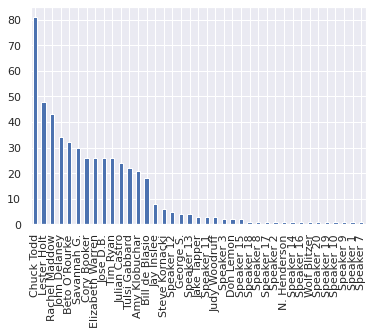

In [84]:
# check who has missing time
df[df.isna().any(axis=1)]['speaker'].value_counts().plot(kind='bar')

A significant fraction of these entries come from moderators/anchors: Chuck Todd, Lester Holt, Rachel Maddow, etc. Removing these entries should have little effect on the data, except in the cases of Elizabeth Warren and Tulsi Gabbard.

The next question to answer is why don't these entries have speaking time.


In [85]:
# Looking at NaN speech
df[df.isna().any(axis=1)]['speech']

153     We have much more today coming up, but we have...
322     Candidates. Thank you. Thanks for a great deba...
669     Candidates, thank you very, very much. That co...
826     We’re going to take a short break and we will be…
1030    We are going to take a very short break. That ...
                              ...                        
4807    But I got my chance. It was a 50 dollar a seme...
4808    We would like to thank all of the candidates t...
4809    We certainly hope you will join us then. But f...
5075                      Mayor Buttigieg, your thoughts.
5332    For now, for all of us at NBC News, I’m Lester...
Name: speech, Length: 513, dtype: object

It appears that a significant portion of these entries are due to commercial breaks and are safe to remove.

In [86]:
# drop the NaN entries
df.dropna(inplace=True)

In [87]:
df.isna().sum() # all clear!

debate_name              0
debate_section           0
speaker                  0
speech                   0
speaking_time_seconds    0
dtype: int64

The next question is what do we do with the moderator questions?
For simplicity, I'm going to throw out everyone I don't care about. Here, I'm going to focus on candidates who made it to the first primary vote:

Bernie Sanders, Elizabeth Warren, Amy Klobuchar,Pete Buttigieg, 
Joe Biden,Tulsi Gabbard, Michael Bloomberg

In [88]:
print(sorted(set(df['speaker'])))

['A. Cooper', 'Abby Phillips', 'Adam Sexton', 'Amna Nawaz', 'Amy Klobuchar', 'Amy Walter', 'Anderson Cooper', 'Andrea Mitchell', 'Andrew Yang', 'Announcer', 'Ashley Parker', 'Audience', 'B. Pfannenstiel', 'Bennett', 'Bernie Sanders', 'Beto O’Rourke', 'Bill de Blasio', 'Brianne P.', 'Chuck Todd', 'Cory Booker', 'Crowd', 'Dana Bash', 'David Muir', 'Devin Dwyer', 'Diana', 'Don Lemon', 'Elizabeth Warren', 'Eric Stalwell', 'Eric Swalwell', 'Erin Burnett', 'Female', 'George S.', 'Hallie Jackson', 'Helen', 'J. Hickenlooper', 'Jake Tapper', 'Jay Inslee', 'Joe Biden', 'John Delaney', 'John H.', 'John Hickenloop', 'John King', 'Jon Ralston', 'Jorge Ramos', 'Jose D.B.', 'Judy Woodruff', 'Julian Castro', 'Kamala Harris', 'Kirseten Gillibrand', 'Kirsten Gillibrand', 'Kristen Welker', 'Lester Holt', 'Linsey Davis', 'Male', 'Marc Lacey', 'Marianne Williamson', 'Michael Bennet', 'Michael Bloomberg', 'Moderator', 'Moderator 1', 'Moderator 2', 'Moderator 4', 'Monica Hernandez', 'N. Henderson', 'Pete But

In [89]:
# select for the people we want
speakers = ['Amy Klobuchar','Bernie Sanders', 'Elizabeth Warren','Joe Biden','Michael Bloomberg','Pete Buttigieg','Tulsi Gabbard']

In [90]:
df = df[df.speaker.isin(speakers)] # only keep the relevant candidates

In [91]:
df.reset_index(inplace=True,drop=True) # resets the index now that we've dropped columns

In [92]:
df.head()

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
2,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
3,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
4,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0


Now that we have our chosen candidates, I want to ensure that I use data from candidates who have enough time to actually say something. Candidates can and do get interupted by both moderators and other candidates.

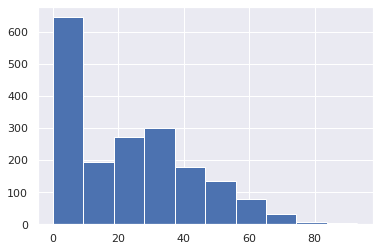

In [93]:
df['speaking_time_seconds'].hist()

There are a lot of entries with < 10 seconds. Now let's look at those entries to see when topics start appearing. I start with a lower threshold of 2 seconds, and an upper threshold of 5 seconds. I realized that many of these entries ended with a dash '-', indicating that the speaker got cutoff or interrupted.

In [94]:
selector = (df['speaking_time_seconds']<5) & (df['speaking_time_seconds']>2)
df[selector]['speech'][df[selector]['speech'].str.endswith("-")]

717                             I want to give a reality-
773     What we owe to those survivors is to actually ...
783     We’ve got to attack the corruption and repeal ...
793           That is why we need a political revolution-
805     I’d like to ask our other candidates this ques...
812        … why it is that we have had laws on the book-
850     You’ve got to take on the greed and the profit...
867     … had to fight against people in his own admin...
1177    And it’s not nearly enough. [crosstalk 00:16:1...
1215    Donald Trump wants to use these people as poli...
1230                 And when 90% of Americans to happen-
1282    And I truly believe that if we’re going to mov...
1323    Four little girls in Birmingham, Alabama lost ...
1474    I reject the premise that there’s only one or ...
1476    We need a political revolution. People have go...
1486    If the government wants to do that, if people ...
1532                        That’s just not true. People-
1599    It jus

Exploring this data, we can see a good example of a speaker getting interrupted, Pete Buttigieg. The indicies are 773-775, and it is just him talking while getting interrupted. The person who interrupted him got removed by dropping the NaN values.

The key to linking statements should be if the same speaker is speaking in adjacent indicies (or maybe) every other, and the previous statement ends with '-' and the next statement starts with '...', stitch them together.

In [95]:
print(df.loc[773]['speech'])
print(df.loc[774]['speech'])
print(df.loc[775]['speech'])

What we owe to those survivors is to actually deliver a solution. I’m glad you offered up-
… that analogy to healthcare because this is really important. We are at the cusp of building a new American majority, to actually do things that congressmen and senators have been talking about with almost no impact for my entire-
… adult life. No, this is really important, okay? On guns, we are this close to an assault weapons ban. That would be huge.


Define a merge function. Which would merge statements like above.

In [96]:
def merge_speaking(df,indicies):
    '''
    df: a copy of the supplied dataframe 
    indicies: a list of that want to add together, accesible by iloc
    '''
    clean_strs = ''
    total_time = 0
    
    for i in indicies:

        # clean the strings
        tmp = (re.sub('-$','',df.loc[i]['speech']))
        tmp = re.sub('^\u2026','',tmp)
        total_time = total_time + df.loc[i]['speaking_time_seconds']
        clean_strs = clean_strs + tmp
    
    # drop the extra rows
    df = df.drop(indicies[1:])
    df.loc[indicies[0],'speech'] = clean_strs
    df.loc[indicies[0],'speaking_time_seconds'] = total_time
    return df
        

In [97]:
# Test case
merge = [773,774,775]
p = merge_speaking(df,merge)
print(p.loc[773]['speech']) #it worked!

What we owe to those survivors is to actually deliver a solution. I’m glad you offered up that analogy to healthcare because this is really important. We are at the cusp of building a new American majority, to actually do things that congressmen and senators have been talking about with almost no impact for my entire adult life. No, this is really important, okay? On guns, we are this close to an assault weapons ban. That would be huge.


Define a function to identify which indicies need to be merged.

In [20]:
def get_merge_indicies(df,speaker):
    indices = []
    tmp = []
    interrupted = False
    for i,row in df[df['speaker']==speaker].iterrows():
        if (not interrupted) and (row['speech'].endswith('-')):
            interrupted = True
            tmp.append(i)

        elif interrupted and row['speech'].startswith('\u2026'):
            tmp.append(i)
            if not row['speech'].endswith('-'):
                indices.append(tmp)
                tmp = []
                interrupted = False
        else:
            interrupted = False
            if len(tmp) > 0:
                if len(tmp) > 1:
                    indices.append(tmp)
                tmp = []
    
    return indices

In [21]:
# get the indices which need appending
all_indices = []
for speaker in speakers:
    speaker_indices = get_merge_indicies(df,speaker)
    all_indices.append(speaker_indices)

In [22]:
for idxs in all_indices:
    for merge in idxs:
        df = merge_speaking(df,merge)

Let's look at whether anything of substance is said in less than one second now that the interrupting segments are merged.

In [23]:
selector = df['speaking_time_seconds'] < 1
df[selector]['speech']

27                                 70 is the new 50.
30                            George, George, can I…
53                                    Let’s do that.
66                                              Yes.
95                          Let’s get that straight.
                            ...                     
1758                                  May I respond?
1766    Can I respond to the Vice President, please?
1789                                           Just-
1797                             You know what Pete?
1824                                      Thank you.
Name: speech, Length: 113, dtype: object

Looks like anything left are short, cute sentences that don't have much content. These can be safely removed as they aren't long enough for topics.

In [24]:
df = df[~selector]

Now, two seconds...

In [25]:
selector = (df['speaking_time_seconds'] <2)
df[selector]['speech']

5                                                I’m not.
41                   I wasn’t able to hear that question.
50                                           There we go.
93           We ought to be able to sue the gun industry.
113                     I don’t think that’s quite right.
                              ...                        
1811                                   Play by the rules.
1813                   Not necessarily. Not till there’s-
1814                                Let the process work.
1817                                                 Yes.
1818    … who has the most votes should become the nom...
Name: speech, Length: 138, dtype: object

Seems like it's okay to remove these too. I see one passage talking about election policy, but I'm looking for larger political topics.

In [26]:
df = df[~selector]

In [27]:
df.reset_index(inplace=True,drop=True) # resets the index now that we've dropped columns

In [28]:
df

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
2,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
3,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
4,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0
...,...,...,...,...,...
1520,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,"Lastly, I think it’s important that on day one...",13.0
1521,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,"Had, in fact, that immigration bill passed the...",5.0
1522,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0
1523,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0


In [29]:
selector = df['speaking_time_seconds']<3
df[selector]['speech'].iloc[10]

'… getting rid of the oil giveaways …'

I'm starting to see words like 'oil' and 'immigration'. These statements need to be kept.

#### If I were to do this project over, I might not have done this. This feels like manually pre-processing the data too much before I see the results

### Topic Modeling

Topic Modeling is a technique to extract hidden topics from a large body of text. The challenge presents itself with how to extract a good number of topics. Ones which are distinct and meaningful.

There are a couple topic modelling algorithms, but I will focus this work on Latent Dirichlet Allocation (LDA). LDA interprets a document as a collection of topics at some proportion. The topics are considered a collection of dominant keywords at some proportion. 

LDA contains two hyper paramters $\alpha$ and $\beta$. $\alpha$ controls the mixture of topics for a document. If $\alpha$ is less than $1$, the dirichlet distribution sampled tends to have peaks near the points of the simplex. $\alpha < 1$ controls the allowed number of topics per document with a lower $\alpha$ meaning less topics per document. 

$\beta$ controls the distribution of words per topic. A lower $\beta$ means topics will have fewer words.

### Preprocessing the Data

The preprocessing of data involves:

#### Tokenization: 
Sentences are split into individual lists of words.

#### Removeal of Stopwords:
Stopwords are words which have no meaning by themselves. They are words like 'of', 'is', 'the', etc. There is no common database for all stopwords. When testing topic modelling, stopwords can also include words which yield low quality topics.

#### Lemmatization:
Converts words into their root form, or lemma. It converts the words 'runs' and 'running' to their lemma, 'run'. It also handles tense. Words like 'went', 'goes', and 'gone' will be converted to their lemma, 'go'.

#### Bigrams and Trigrams:
Bigrams and trigrams. These are series of two or three words which appear next to each other.

#### Choosing Stopwords

I am using a list provided by the natural language processing toolkit (nltk).

Extended stop words are words I've chosen to remove, in addition to the standard dictionary I'm using. These words are chosen in order to create higher quality topics.

In [30]:
# stopwords filter out words which make the topics have low quality
from nltk.corpus import stopwords

In [31]:
# load the stopwords and add some of my own
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','question','time','things','thing','com'])

#### Tokenization
Here I need to break up the setences into a list of individual words. This means I need to expand contractions, remove puncuation, and remove weird characters in the text.

In [32]:
data = df.speech.tolist()
# remove ellipses
data = [re.sub('\u2026', '', response) for response in data]   

Next we need to remove things like '[crosstalk ##:##:##]' or '[inaudible ##:##:##]'

In [33]:
data = [re.sub('.crosstalk [0-9][0-9]:[0-9][0-9]:[0-9][0-9]..','',response) for response in data]
data = [re.sub('.inaudible [0-9][0-9]:[0-9][0-9]:[0-9][0-9]..','',response) for response in data]

In [34]:
# cp1252 to unicode encoding for the apostrophe
data = [re.sub("\u2019","\u0027",response) for response in data]

##### Expand contractions

Words like 'don't' will be converted into its uncontracted form: 'do' and 'not'

Here I am using a package called pycontractions.

In [35]:
# model for contractions function
# from disk, takes awhile to load
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

# not from disk 
#model = api.load("word2vec-google-news-300")

In [36]:
cont = Contractions(kv_model=model)

In [37]:
# prevents loading on first expand_texts call
cont.load_models()

In [38]:
# expand contractions, takes awhile
data = list(cont.expand_texts(data,precise=True))

In [39]:
# freeing up memory
%reset_selective -f "^model$"
%reset_selective -f "^cont$"

#### Tokenize

In [40]:
def tokenize(sentences):
    # lowercase, tokenizes, de-accents
    return [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in sentences]
    
   # for sentence in sentences:
        # lowercase, tokenizes, de-accents   
    #    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [41]:
token_sentences = list(tokenize(data))

#### Building Bigrams and Trigrams

In [42]:
bigram = gensim.models.Phrases(token_sentences, min_count=5,threshold=100)
trigram = gensim.models.Phrases(bigram[token_sentences],threshold=100)

In [43]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

While playing around with the models, I noticed that none of the n-grams were all the important to the topics. Creating n-grams seems to make it harder for topic modelling as it increases the vocabulary. The number of topics may need to increase as well.

In [44]:
# necessary functions -- borrowed functions

def remove_stopwords(docs):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in docs]

def make_bigrams(docs):
    return [bigram_mod[doc] for doc in docs]

def make_trigrams(docs):
    return [trigram_mod[bigram_mod[doc]] for doc in docs]

def lemmatization(docs,allowed_postags=['NOUN', 'ADJ', 'PROPN']):
        docs_out = []
        for doc in docs:
            joined_doc = nlp(" ".join(doc)) 
            docs_out.append([token.lemma_ for token in joined_doc if token.pos_ in allowed_postags])
        return docs_out  

In [45]:
# remove stopwords
nostops = remove_stopwords(token_sentences)

In [46]:
# make bigrams and trigrams
bigrams = make_bigrams(nostops)
trigrams = make_trigrams(nostops)

In [47]:
# loads spaCy model by name
nlp = spacy.load('en', disable=['parser','ner'])

Here I use spaCy package for lemmatization. I also remove words which are not nouns, adjectives, and pronouns.

In [48]:
# lemmatize - trigrams
lemmatized = lemmatization(nostops)

In [49]:
# Create Dictionary
id2word = corpora.Dictionary(lemmatized)

# Create Corpus
corpus = [id2word.doc2bow(doc) for doc in lemmatized]

# mapping (word_id, word_frequency)

In [50]:
id2word[0] # dictionary usage

'bernie'

### Metrics
There are two metrics generally used to evaluate the model in order to get an idea of how good the topic model is: perplexity and coherence.

Perplexity is a measure for how surprised a model is of a held-out data set. It is defined as $2^{H(\tilde{p},q)}$, where $H(\tilde{p},q)$ is the cross-entropy between, our sample distribution, $\tilde{p}$, and our model, $q$. Using perplexity as the sole metric does not necessarily lead to human-interprettable results.

Topic coherence attempts to incorporate human judgement. It measures the degree of semantic similarity between words in a topic. In other words, 'how much of word A has to do with word B?'.

### Parameters Tuning
There are 3 paramters we can tune in an LDA model: the number of topics, $\alpha$, and $\beta$.

In [51]:
# Helper function to Compute Coherence

def compute_coherence_test(train, validation, num_topics, alpha='auto', eta=None):
    lda_model = gensim.models.LdaMulticore(corpus=train,
                                           id2word=id2word,
                                           num_topics=num_topics, #6
                                           random_state=200,
                                           #update_every=1,
                                           chunksize=100,
                                           passes=15, #15
                                           eta = eta,
                                           alpha=alpha,
                                           per_word_topics=True)

    coherence_model = CoherenceModel(model=lda_model, texts=validation, dictionary=id2word,coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    return coherence_lda#, lda_model

In [52]:
# Setting up search space

# Topics range
min_topics = 4
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha
alphas = list(np.arange(0.01, 1, 0.3))
alphas.append('symmetric')
alphas.append('asymmetric')

# Beta
betas = list(np.arange(0.01, 1, 0.3))
betas.append('symmetric')

In [53]:
# splitting into train and validation set
num_of_docs = len(corpus)
num_train_docs = int(num_of_docs*0.75)

train = corpus[:num_train_docs]
#validate = lemmatized[num_train_docs:]
validate = lemmatized

In [54]:
results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for topics in topics_range:
    for alpha in alphas:
        for beta in betas:
            cs = compute_coherence_test(train, validate, num_topics = topics, alpha = alpha, eta = beta)
            
            results['Topics'].append(topics)
            results['Alpha'].append(alpha)
            results['Beta'].append(beta)
            results['Coherence'].append(cs)
            
    print('Completed Run Topics: ', topics)

Completed Run Topics:  4
Completed Run Topics:  5
Completed Run Topics:  6
Completed Run Topics:  7
Completed Run Topics:  8
Completed Run Topics:  9
Completed Run Topics:  10
Completed Run Topics:  11


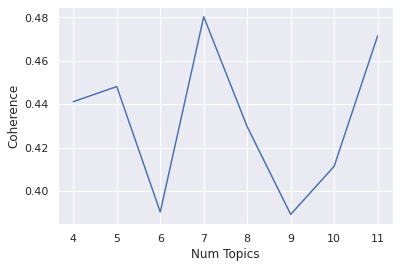

In [104]:
plt.xlabel('Num Topics')
plt.ylabel('Coherence')
plt.plot(results['Topics'][::30],results['Coherence'][::30])

In [56]:
print('Topics: ',results['Topics'][126],
      'alpha: ', results['Alpha'][126],
'beta: ',results['Beta'][126],
'coherence: ',results['Coherence'][126])

Topics:  8 alpha:  0.31 beta:  0.31 coherence:  0.5100544774675315


In [57]:
print('Topics: ',results['Topics'][70],
      'alpha: ', results['Alpha'][70],
'beta: ',results['Beta'][70],
'coherence: ',results['Coherence'][70])

Topics:  6 alpha:  0.61 beta:  0.01 coherence:  0.5286316684348681


In [58]:
print('Topics: ',results['Topics'][146],
      'alpha: ', results['Alpha'][146],
'beta: ',results['Beta'][146],
'coherence: ',results['Coherence'][146])

Topics:  8 alpha:  asymmetric beta:  0.31 coherence:  0.5210606363379038


It appears the optimal topic range is somewhere between 6-8 topics.

### Train the Model

Training the LDA model. The model parameters were tuned based on a balance between maximizing the coherence, and eyeballing topics such that they make sense.

Here I played around with the suggested parameters. I found eta = 0.01 allowed for too much overlap of words, but eta close to one did not allow for enough over lap. So words like 'people' which are spoken very often, get placed into one category. That category then dominates.

In [59]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=train,
                                           id2word=id2word,
                                           num_topics=6, #6
                                           random_state=200,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20, #15
                                           eta = 0.31, # 4
                                           alpha=0.4, #31
                                           per_word_topics=True)

In [60]:
# using validation set doesn't work because of unseen words?
coherence_model = CoherenceModel(model=lda_model, texts=validate, dictionary=id2word,coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('Coherence: ',coherence_lda)

Coherence:  0.42342622279445385


In [61]:
# print the topics and 10 most associated words
pprint(lda_model.print_topics())

[(0,
  '0.025*"plan" + 0.023*"year" + 0.021*"insurance" + 0.019*"people" + '
  '0.015*"medicare" + 0.015*"school" + 0.014*"health" + 0.014*"care" + '
  '0.013*"healthcare" + 0.013*"public"'),
 (1,
  '0.051*"people" + 0.025*"country" + 0.020*"america" + 0.015*"american" + '
  '0.013*"system" + 0.012*"big" + 0.010*"way" + 0.009*"trump" + 0.009*"money" '
  '+ 0.008*"company"'),
 (2,
  '0.031*"world" + 0.020*"trade" + 0.019*"climate" + 0.017*"worker" + '
  '0.017*"nuclear" + 0.016*"deal" + 0.015*"change" + 0.014*"job" + '
  '0.014*"agreement" + 0.010*"china"'),
 (3,
  '0.051*"president" + 0.017*"united" + 0.015*"country" + 0.015*"states" + '
  '0.015*"war" + 0.012*"trump" + 0.012*"year" + 0.011*"congress" + '
  '0.011*"military" + 0.010*"way"'),
 (4,
  '0.011*"record" + 0.009*"court" + 0.008*"committee" + 0.008*"general" + '
  '0.008*"son" + 0.007*"justice" + 0.006*"constitutional" + 0.006*"side" + '
  '0.006*"brother" + 0.006*"john"'),
 (5,
  '0.020*"woman" + 0.017*"number" + 0.014*"sure"

##### Topic 0: Healthcare
plan, year, insurance, people, medicare, school health, care, healthcare, public

##### Topic 1: Americans
people, country, america, american, system, big, way, trump, money, company

##### Topic 2: Global Issues
world, trade, climate, worker, numclear, deal, change, job, agreement, china

##### Topic 3: The President
president, united, country, states, war, trump, year, congress, military, way

##### Topic 4: Judicial System
record, court, committee, general, son, justice, constitutinal, side, brother, john

##### Topic 5: Social Justice Issues
woman, number, sure, bill, able, people, border, black, state, immigration

### Visualization

In [62]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

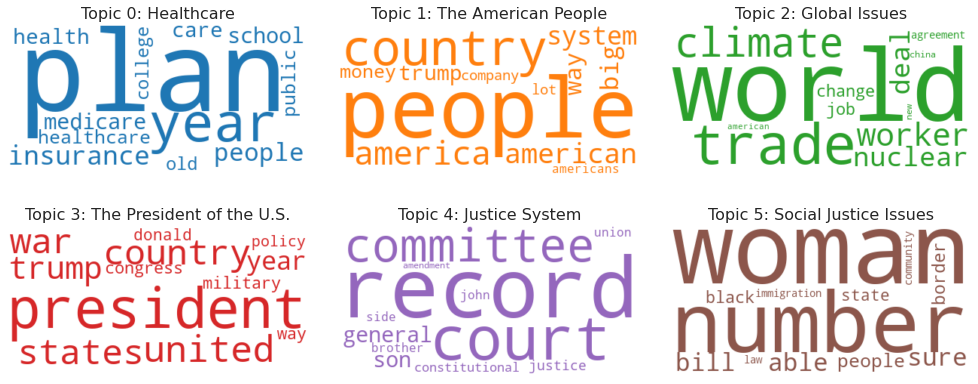

In [63]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  color_func=lambda *args, **kwargs: cols[i],
                 )
                 

topics = lda_model.show_topics(num_words=12,formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(14,6),sharex=True, sharey=True)

topic_dict = {0 : 'Healthcare', 1 : 'The American People', 
                  2:'Global Issues',3:'The President of the U.S.',
                 4:'Justice System',5:'Social Justice Issues'}

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=150)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i) + ': ' + topic_dict[i], fontdict=dict(size=16))
    plt.gca().axis('off')



plt.axis('off')
plt.tight_layout()
plt.show()

This is a visualization tool for LDA. It displays a two-dimensional principle component analysis (PCA) plot of the topics. I used this to prevent topics from having severe overlap. This method has its limitations as projecting a high dimensional space onto two dimensions can make separated topics appear to heavily over lap.

This tool pops open a new interactive window and does not display in this notebook.

In [64]:
pyLDAvis.enable_notebook()

In [65]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [106]:
#pyLDAvis.display(vis, template_type='notebook')
pyLDAvis.show(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [22/Mar/2020 19:14:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Mar/2020 19:14:44] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [22/Mar/2020 19:14:44] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Mar/2020 19:14:44] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


### Speakers

Now we turn back to evaluating speakers. What speaker talks the most about which topic? To determine this, I will use the ldamodel to find a probability distribution for each response. I will label the document by a single topic, the one which has the highest probability. This, of course, is a simplified view of what is going on, as each response can contain one or more of these topics. 

In [67]:
# Define a function to get the associated topic probabilities
def get_doc_topics(bow,lda_model):
    '''
    Takes doc text in bag-of-words form and a trained lda_model
    to return the probabilities that each document belongs to a
    specific topic.
    '''
    doc_topics = []
    for doc in bow:
        doc_topics.append(np.array(lda_model.get_document_topics(doc)))
    return doc_topics

In [68]:
doc_topics = get_doc_topics(corpus,lda_model)

In [107]:
# Assign document the topic with the highest probability
highest_prob = []
for doc in doc_topics:    
    highest_prob.append(doc[np.argmax(doc[:,1])][0])

In [70]:
df['Topic'] = highest_prob

In [71]:
# creating sub dataframes -- normalizing speaking time
biden = df[df.speaker == 'Joe Biden']
biden.speaking_time_seconds = biden.speaking_time_seconds/biden.speaking_time_seconds.sum()
sanders = df[df.speaker == 'Bernie Sanders']
sanders.speaking_time_seconds = sanders.speaking_time_seconds/sanders.speaking_time_seconds.sum()
klobuchar = df[df.speaker == 'Amy Klobuchar']
klobuchar.speaking_time_seconds = klobuchar.speaking_time_seconds/klobuchar.speaking_time_seconds.sum()
warren = df[df.speaker == 'Elizabeth Warren']
warren.speaking_time_seconds = warren.speaking_time_seconds/warren.speaking_time_seconds.sum()
buttigieg = df[df.speaker == 'Pete Buttigieg']
buttigieg.speaking_time_seconds = buttigieg.speaking_time_seconds/buttigieg.speaking_time_seconds.sum()
gabbard = df[df.speaker == 'Tulsi Gabbard']
gabbard.speaking_time_seconds = gabbard.speaking_time_seconds/gabbard.speaking_time_seconds.sum()
bloomberg = df[df.speaker == 'Michael Bloomberg']
bloomberg.speaking_time_seconds = bloomberg.speaking_time_seconds/bloomberg.speaking_time_seconds.sum()

#### Joe Biden

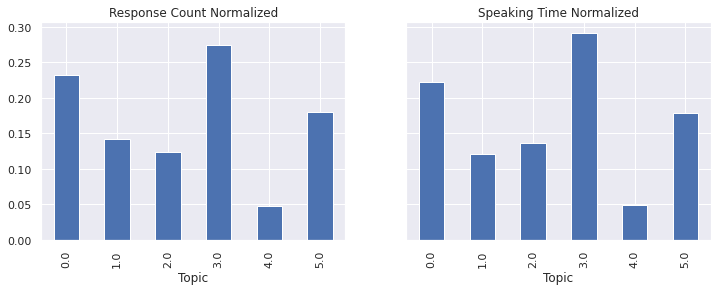

In [72]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
biden.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Response Count Normalized')
ax[1].set_title('Speaking Time Normalized')
biden.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

#### Bernie Sanders

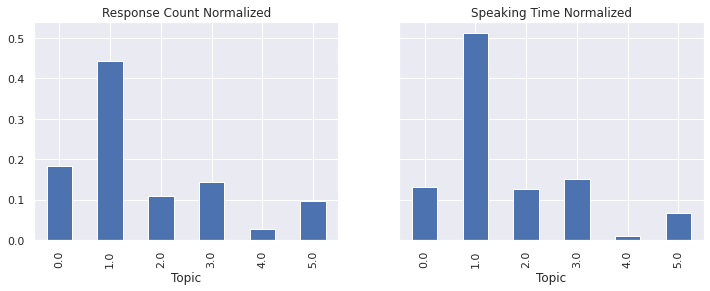

In [73]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
sanders.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Response Count Normalized')
ax[1].set_title('Speaking Time Normalized')
sanders.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

#### Amy Klobuchar

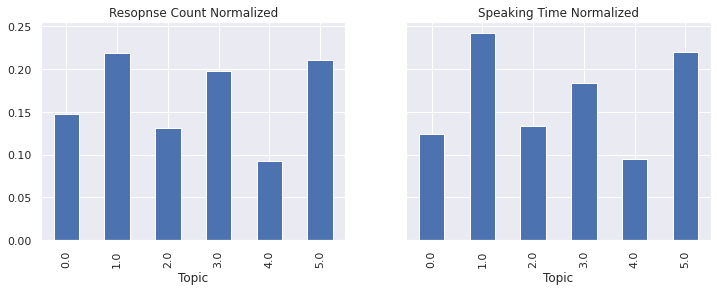

In [74]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
klobuchar.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Resopnse Count Normalized')
ax[1].set_title('Speaking Time Normalized')
klobuchar.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

#### Elizabeth Warren

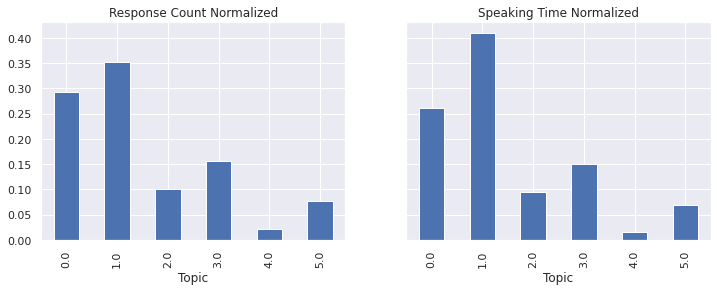

In [75]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
warren.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Response Count Normalized')
ax[1].set_title('Speaking Time Normalized')
warren.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

#### Pete Buttigieg

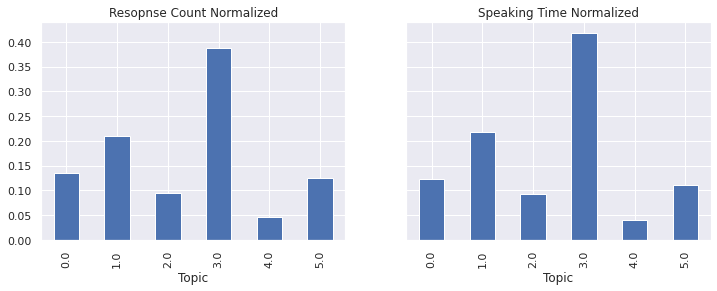

In [76]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
buttigieg.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Resopnse Count Normalized')
ax[1].set_title('Speaking Time Normalized')
buttigieg.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

#### Tulsi Gabbard

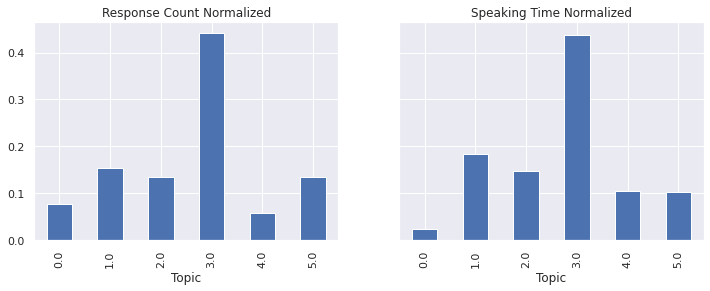

In [77]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
gabbard.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Response Count Normalized')
ax[1].set_title('Speaking Time Normalized')
gabbard.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

#### Michael Bloomberg

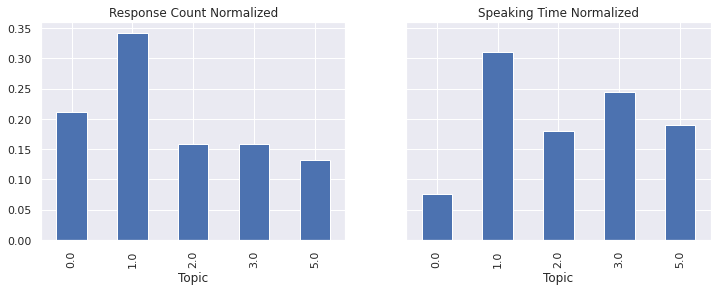

In [78]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
bloomberg.Topic.value_counts(normalize=True).sort_index().plot.bar(ax=ax[0])
ax[0].set_xlabel('Topic')
ax[0].set_title('Response Count Normalized')
ax[1].set_title('Speaking Time Normalized')
bloomberg.groupby(by='Topic').speaking_time_seconds.sum().plot.bar(ax=ax[1])

It appears that the primary topics for most speakers are talking about the american people (topic 1) and the President of the United States (topic 3).

Elizabeth Warren spent more of her speaking time focussing on healthcare (topic 0) and the american people. This is an unsurprising result as Elizabeth Warren includes adjustments to Medicare in her promise for her first 100 days.

What is surprising to me is that Bernie Sander's histogram doesn't look much like Elizabeth Warren's. Bernie Sander's frequently talked about healthcare via his 'Medicare for All' plan. If we look at topic 0, we see that 'medicare' is not one of the 10 highest words.

### Things that could be improved

I went into this project knowing virtually nothing about NLP, so I'm sure there's a lot which could be improved beyond what I list here.

- If I wanted to keep more of the data, I could potentially analyze the number of works spoken for those missing speaking_time entries and estimate how much times is taken up by those sections using the average words spoken.

- I removed short segments based on eye-balling the topics. I could have looked at the distribution of words for all time segments, after removing stop words, and see when words related to policy show up.

- Keep moderator questions. If I kept moderator questions, I could ask more questions about whether the candidate avoided the question.

- Allow for multiple topic documents. I took a naive approach where a document is assigned a topic by taking the topic with the highest probability. We know this isn't true, and in fact, we trained the model assuming there are multiple topics per document.

- Improve topic model coherence due with regulation? https://www.researchgate.net/publication/260639294_Improving_Topic_Coherence_with_Regularized_Topic_Models

- k-fold cross-validation?

- frequency distribution of words, comparing classified documents and the topic model

- By topic graphs would be easier to compare candidates